<a href="https://colab.research.google.com/github/tangYang7/GAI/blob/main/exercise/week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 0. Install and Import Parkage

In [ ]:
!pip install gradio

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# for interactive design
from ipywidgets import interact_manual

# Gradio for creating web apps quickly
import gradio as gr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

## 1. Read MNIST Corpus and Pre-processing

MNIST is a library of handwritten numerical images with a bunch of 0-9. There are 60,000 training data and 10,000 test data. It is the "Modified" version of the NIST database, and the original version has more information. This Modified version was made by LeCun, Cortes, and Burges. You can refer to the [original web page of this database](http://yann.lecun.com/exdb/mnist/).



MNIST can be said to be the most famous example of Deep Learning, and it is called the "drosophile of machine learning" by Deep Learning master Hinton.

In [ ]:
trainset=torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=torchvision.transforms.ToTensor())
testset=torchvision.datasets.MNIST(root='./data',train=False,download=True,transform=torchvision.transforms.ToTensor())

### The training set has 60,000 samples, whereas the test set has 10,000.

In [ ]:
print(f'訓練資料總筆數為 {len(trainset)} 筆資料')
print(f'測試資料總筆數為 {len(testset)} 筆資料')

訓練資料總筆數為 60000 筆資料
測試資料總筆數為 10000 筆資料


In [ ]:
def dataset_get_xy(input_dataset):
    x = torch.stack([image.squeeze(0) for image, _ in input_dataset])
    y = torch.tensor([label for _, label in input_dataset])
    return x, y

train_x, train_y = dataset_get_xy(trainset)
test_x, test_y = dataset_get_xy(testset)

### Take a look at the picture and label

In [ ]:
def show_xy(n=0):
  ax = plt.gca()
  X = train_x[n]
  plt.xticks([], [])
  plt.yticks([], [])
  plt.imshow(X, cmap = 'Greys')
  print(f'本資料 y 給定的答案為: {train_y[n]}')

In [ ]:
interact_manual(show_xy, n=(0,59999));

interactive(children=(IntSlider(value=0, description='n', max=59999), Button(description='Run Interact', style…

#### Example of above results:

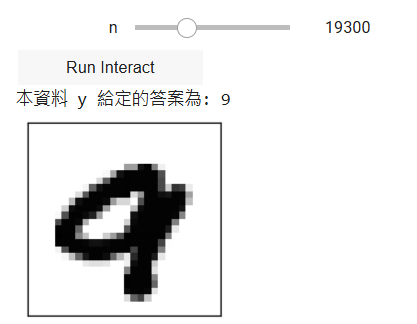

### Take a look at the data

In [ ]:
def show_data(n = 100):
  X = train_x[n]
  print(X.shape)
  print(X)

In [ ]:
interact_manual(show_data, n=(0,59999));

interactive(children=(IntSlider(value=100, description='n', max=59999), Button(description='Run Interact', sty…

In [ ]:
train_x = train_x.reshape(train_x.shape[0], -1)
test_x = test_x.reshape(test_x.shape[0], -1)

### The label is a number. For training, we convert it into representation of one-hot encoding

In [ ]:
n = 87
train_y[n]

tensor(9)

In [ ]:
train_y = F.one_hot(train_y, num_classes=10)
test_y = F.one_hot(test_y, num_classes=10)

In [ ]:
train_y[n]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

## 2. Build a network model

我們決定了我們的函數是

$$\hat{f} \colon \mathbb{R}^{784} \to \mathbb{R}^{10}$$

這個樣子。而我們又說第一次要用標準神網路試試, 所以我們只需要再決定要幾個隱藏層、每層要幾個神經元, 用哪個激發函數就可以了。

In [ ]:
Model_config = {
  "N1_dim": 20,
  "N2_dim": 30,
  "N3_dim": 30,
  "N4_dim": 20,
  "input_dim": train_x.shape[1],
  "output_dim": 10,
}

In [ ]:
class DNN_Classifier(nn.Module):
    def __init__(self, config):
        super(DNN_Classifier, self).__init__()
        self.fc1 = nn.Linear(784, config["N1_dim"])
        self.fc2 = nn.Linear(config["N1_dim"], config["N2_dim"])
        self.fc3 = nn.Linear(config["N2_dim"], config["N3_dim"])
        self.fc4 = nn.Linear(config["N3_dim"], config["N4_dim"])
        self.fc5 = nn.Linear(config["N4_dim"], config["output_dim"])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def decoding(self, x):
        logit = F.softmax(x, dim=1)
        pred = torch.argmax(logit, dim=1)
        return logit, pred

In [ ]:
model = DNN_Classifier(config=Model_config)
model

DNN_Classifier(
  (fc1): Linear(in_features=784, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=30, bias=True)
  (fc4): Linear(in_features=30, out_features=20, bias=True)
  (fc5): Linear(in_features=20, out_features=10, bias=True)
)

## 3. Training

In [ ]:
training_config = {
  "batch_size": 100,
  "epoch": 100,
  "learning_rate": 0.01,

}
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=training_config["learning_rate"])

In [ ]:
# prompt: training (generated by AI)
losses = []
for epoch in range(training_config["epoch"]):
  epoch_loss = 0
  for i in range(0, len(train_x), training_config["batch_size"]):
    x = train_x[i:i+training_config["batch_size"]]
    y = train_y[i:i+training_config["batch_size"]]
    optimizer.zero_grad()
    y_hat = model(x.float())
    loss = criterion(y_hat, y.float())
    loss.backward()
    optimizer.step()
    epoch_loss += loss.item()
  losses.append(epoch_loss)
  if epoch % 10 == 0 or epoch == training_config["epoch"] - 1:
    print(f"Epoch {epoch+1}/{training_config['epoch']}, Loss: {epoch_loss:.4f}")

Epoch 1/100, Loss: 50.2333
Epoch 11/100, Loss: 46.8568
Epoch 21/100, Loss: 43.5986
Epoch 31/100, Loss: 40.7086
Epoch 41/100, Loss: 38.1179
Epoch 51/100, Loss: 35.6740
Epoch 61/100, Loss: 33.2596
Epoch 71/100, Loss: 31.2156
Epoch 81/100, Loss: 29.2001
Epoch 91/100, Loss: 27.2360
Epoch 100/100, Loss: 26.0182


## 4. Evaluate in testset

In [ ]:
pred = []
with torch.no_grad():
  test_x = test_x.float()
  y_hat = model(test_x)
  loss = criterion(y_hat, torch.argmax(test_y.float(), dim=1))

  _, predicted = model.decoding(y_hat)
  pred.append(predicted)
  pred = torch.cat(pred, dim=0)
  print(len(pred))
  correct = (predicted == torch.argmax(test_y, dim=1)).sum().item()
  accuracy = correct / len(test_x)
  print(f"Test Loss: {loss:.4f}")
  print(f"Test Accuracy: {accuracy * 100:.4f}%")

10000
Test Loss: 0.2308
Test Accuracy: 95.1600%


In [ ]:
def test(test_id):
    plt.imshow(test_x[test_id].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', pred[test_id].item())

In [ ]:
interact_manual(test, test_id=(0, 9999));

interactive(children=(IntSlider(value=4999, description='test_id', max=9999), Button(description='Run Interact…

### the correct and wrong examples of prediction:
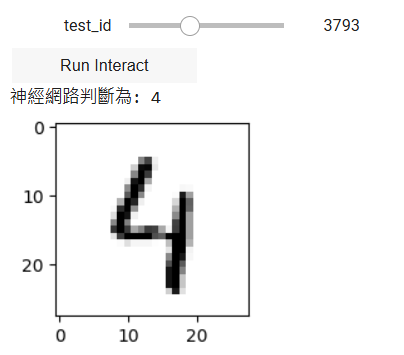
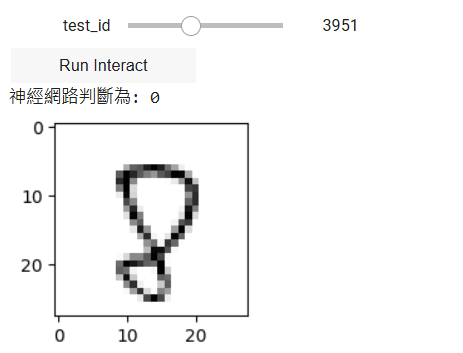

### Draw confusion matrix (generated by AI)

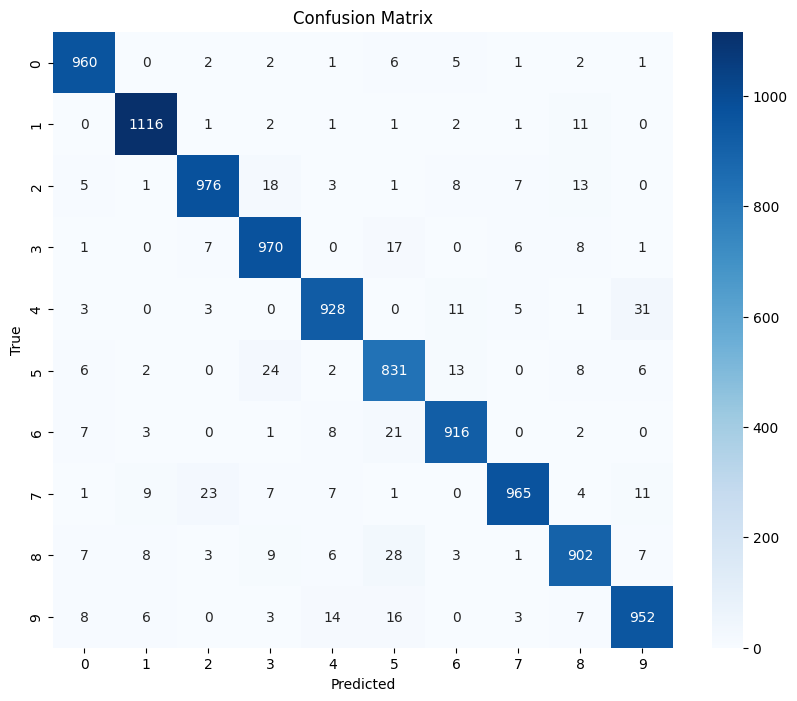

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

pred_np = pred.numpy()
true_labels_np = torch.argmax(test_y, dim=1).numpy()

cm = confusion_matrix(true_labels_np, pred_np)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


### Results and Discussion:
- The model performs well on most samples.
- The most easily confused pairs for the model are:
  - 5 and 3
  - 4 and 9
  - 5 and 8